This notebook is used to do some exploration of variable importance and to create a baseline MLR model.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import time
import seaborn as sns
import tabulate

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor # for feature importance
from xgboost import XGBRegressor # for feature importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
plt.style.use("seaborn")

/Users/margaretsabelhaus/opt/anaconda3/envs/dsci/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Read in CSV from github repository
connecticut = pd.read_csv("data/connecticutData.csv")

In [3]:
connecticut.head()

,LocalDt,Date,DateTimeObj,D,M,Y,LoadMW,LoadMW_Plus1,TempF,Humidity,Holiday,Spring,Summer,Winter,Fall,cos_HourE,sin_HourE,cos_DOW,sin_DOW,OnPeak
0,10/22/2018 0:00,2018-10-22,2018-10-22 00:00:00,22,10,2018,2470.0,2397.0,34.0,75.0,0,0,0,0,1,0.965926,0.258819,1.0,0.0,0
1,10/22/2018 1:00,2018-10-22,2018-10-22 01:00:00,22,10,2018,2397.0,2374.6,30.9,78.0,0,0,0,0,1,0.866025,0.500000,1.0,0.0,0
2,10/22/2018 2:00,2018-10-22,2018-10-22 02:00:00,22,10,2018,2374.6,2392.0,28.9,89.0,0,0,0,0,1,0.707107,0.707107,1.0,0.0,0
3,10/22/2018 3:00,2018-10-22,2018-10-22 03:00:00,22,10,2018,2392.0,2486.2,30.0,88.0,0,0,0,0,1,0.500000,0.866025,1.0,0.0,0
4,10/22/2018 4:00,2018-10-22,2018-10-22 04:00:00,22,10,2018,2486.2,2751.4,30.9,82.0,0,0,0,0,1,0.258819,0.965926,1.0,0.0,0


In [4]:
# First let's create the set of days I want to hold out
# This will be 12 weeks, one from each month, and in the months we have the most current data for

test_dates = ['2020-11-08','2020-11-09','2020-11-10','2020-11-11','2020-11-12','2020-11-13','2020-11-14','2020-12-20','2020-12-21','2020-12-22','2020-12-23','2020-12-24','2020-12-25','2020-12-26','2021-01-24','2021-01-25','2021-01-26','2021-01-27','2021-01-28','2021-01-29','2021-01-30','2021-02-14','2021-02-15','2021-02-16','2021-02-17','2021-02-18','2021-02-19','2021-02-20','2021-03-07','2021-03-08','2021-03-09','2021-03-10','2021-03-11','2021-03-12','2021-03-13','2021-04-11','2021-04-12','2021-04-13','2021-04-14','2021-04-15','2021-04-16','2021-04-17','2021-05-23','2021-05-24','2021-05-25','2021-05-26','2021-05-27','2021-05-28','2021-05-29','2021-06-13','2021-06-14','2021-06-15','2021-06-16','2021-06-17','2021-06-18','2021-06-19','2021-07-18','2021-07-19','2021-07-20','2021-07-21','2021-07-22','2021-07-23','2021-07-24','2021-08-15','2021-08-16','2021-08-17','2021-08-18','2021-08-19','2021-08-20','2021-08-21','2021-09-05','2021-09-06','2021-09-07','2021-09-08','2021-09-09','2021-09-10','2021-09-11','2021-10-24','2021-10-25','2021-10-26','2021-10-27','2021-10-28','2021-10-29','2021-10-30']
test_df = connecticut[connecticut['Date'].isin(test_dates)]
train_df = connecticut[~connecticut['Date'].isin(test_dates)]

features = ['LoadMW','TempF','Humidity','Holiday','Spring','Summer','Winter','Fall','cos_HourE','sin_HourE','cos_DOW','sin_DOW','OnPeak']
target = 'LoadMW_Plus1'

## Feature importance

As a first step I consider feature importance. I will run a random forest regressor and boosted tree using the features available and create a visual to see variable importance.

In [5]:
# Random forest
forest = RandomForestRegressor(random_state=0)
forest.fit(train_df[features], train_df[target])

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
print(importances)

forest_importances = pd.Series(importances, index=features)

#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances (Random Forest)")
#ax.set_ylabel("Mean decrease in error")
#fig.tight_layout()

Elapsed time to compute the importances: 0.095 seconds
[9.51664582e-01 7.24236723e-03 1.36131631e-03 3.93577182e-05
 2.14248235e-04 3.04524235e-04 1.48965900e-04 1.87455175e-04
 3.04808369e-02 7.32718012e-03 4.46893009e-04 3.48732135e-04
 2.33540938e-04]


In [6]:
# Boosted tree
model = XGBRegressor()
model.fit(train_df[features], train_df[target])
print(model.feature_importances_)

boost_importances = pd.Series(model.feature_importances_, index=features)

#fig, ax = plt.subplots()
#boost_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances")
#ax.set_ylabel("Mean decrease in error")
#fig.tight_layout()

/Users/margaretsabelhaus/opt/anaconda3/envs/dsci/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0.8815871  0.01184179 0.00162225 0.00241656 0.0043564  0.00595367
 0.00415066 0.00283305 0.06019266 0.01514071 0.00184978 0.00276937
 0.00528601]


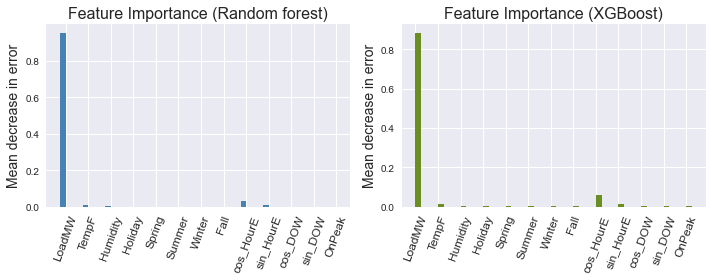

In [7]:
n=13
r = np.arange(n)
width = 0.25

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
fig.subplots_adjust(wspace=0.4, hspace=0.4)


ax1.bar(r, forest_importances, color='steelblue',
		width = width)
ax2.bar(r + width, boost_importances, color='olivedrab',
		width = width)

ax1.set_title("Feature Importance (Random forest)", fontdict = {'fontsize' : 16})
ax2.set_title("Feature Importance (XGBoost)", fontdict = {'fontsize' : 16})
ax1.set_ylabel("Mean decrease in error", fontdict = {'fontsize' : 14})
ax2.set_ylabel("Mean decrease in error", fontdict = {'fontsize' : 14})
ax1.set_xticks(r + width/2)
ax2.set_xticks(r + width/2)
ax1.set_xticklabels(features, rotation=70, fontsize=12)
ax2.set_xticklabels(features, rotation=70, fontsize=12)

fig.tight_layout()

plt.show()
#plt.savefig('figures/feature_importance_1.eps', format='eps')

LoadMW is definitely the most important feature, as expected. I will remove it and rerun these models to see if any other features become important.

Elapsed time to compute the importances: 0.077 seconds
[0.55786795 0.04777931 0.00067731 0.04153021 0.0067862  0.02409131
 0.02154341 0.06884207 0.07221325 0.01052256 0.00775525 0.14039117]


/Users/margaretsabelhaus/opt/anaconda3/envs/dsci/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0.14058714 0.00891758 0.00819395 0.1186354  0.01741749 0.08843555
 0.05632062 0.04595411 0.05990662 0.00669497 0.00964833 0.43928826]


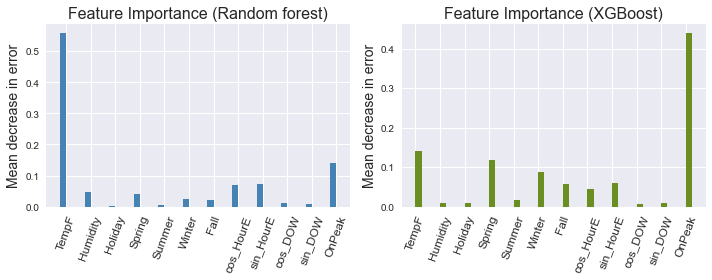

In [8]:
# Rerunning models without LoadMW

features = ['TempF','Humidity','Holiday','Spring','Summer','Winter','Fall','cos_HourE','sin_HourE','cos_DOW','sin_DOW','OnPeak']
target = 'LoadMW_Plus1'

# Random forest
forest = RandomForestRegressor(random_state=0)
forest.fit(train_df[features], train_df[target])

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
print(importances)

forest_importances = pd.Series(importances, index=features)

# Boosted tree
model = XGBRegressor()
model.fit(train_df[features], train_df[target])
print(model.feature_importances_)

boost_importances = pd.Series(model.feature_importances_, index=features)

n=12
r = np.arange(n)
width = 0.25

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
fig.subplots_adjust(wspace=0.4, hspace=0.4)


ax1.bar(r, forest_importances, color='steelblue',
		width = width)
ax2.bar(r + width, boost_importances, color='olivedrab',
		width = width)

ax1.set_title("Feature Importance (Random forest)", fontdict = {'fontsize' : 16})
ax2.set_title("Feature Importance (XGBoost)", fontdict = {'fontsize' : 16})
ax1.set_ylabel("Mean decrease in error", fontdict = {'fontsize' : 14})
ax2.set_ylabel("Mean decrease in error", fontdict = {'fontsize' : 14})
ax1.set_xticks(r + width/2)
ax2.set_xticks(r + width/2)
ax1.set_xticklabels(features, rotation=70, fontsize=12)
ax2.set_xticklabels(features, rotation=70, fontsize=12)

fig.tight_layout()

#plt.show()
plt.savefig('figures/feature_importance_2.eps', format='eps')

Results indicate that TempF and OnPeak are both relatively important. In addition, the random forest suggests that the cyclically encoded hours may be important. The boosted tree suggests that Spring, Winter, and Fall may be important as well.

I attempted best subset selection and forward stepwise selection--both were taking an extremely long time and thus I determined they were not worth exploring further.

In [9]:
# Looking at correlation of our target and features
temp_data = train_df.copy()
temp_data.drop(['LocalDt','Date','D','M','Y'],axis = 1, inplace = True)
temp = abs(temp_data.corr()['LoadMW_Plus1'].sort_values(ascending = False))
print(temp.sort_values(ascending = False).to_markdown())

|              |   LoadMW_Plus1 |
|:-------------|---------------:|
| LoadMW_Plus1 |      1         |
| LoadMW       |      0.974859  |
| OnPeak       |      0.456423  |
| sin_HourE    |      0.424568  |
| Summer       |      0.393332  |
| cos_HourE    |      0.354007  |
| Spring       |      0.332965  |
| TempF        |      0.267934  |
| Humidity     |      0.211154  |
| Fall         |      0.189356  |
| Winter       |      0.131248  |
| cos_DOW      |      0.0912372 |
| sin_DOW      |      0.0835099 |
| Holiday      |      0.030304  |


As expected, LoadMW is highly correlated with my target. OnPeak and sin_HourE are also both relatively correlated, which agrees with the results from the random forest/boosted tree. TempF is surprisingly not very correlated, meaning it potentially may not be helpful to include.

Since Summer and Spring are both relatively correlated with my target, but Winter and Fall are not, I decide to create dummies instead for warm/cool months.

In [10]:
# Create one-hot encoding of warm/cool months

# First create season variable
def f(month):
    if month in [12,1,2,3,4,5]:
        return "WarmMonth"
    else:
        return "CoolMonth"

# Adding in season variable
connecticut["MonthType"] = connecticut["M"].apply(f)

# Make dummies for season and drop 
connecticut = connecticut.join(pd.get_dummies(connecticut['MonthType']))
connecticut = connecticut.drop("MonthType", axis = 1)

In [11]:
# Now I rerun the correlation function, dropping features that did not seem important
train_df = connecticut[~connecticut['Date'].isin(test_dates)]

variables = ['LoadMW_Plus1','LoadMW','TempF','Humidity','cos_HourE','sin_HourE','OnPeak','WarmMonth']

train_df = train_df[variables]

# Looking at correlation of our target and features
temp_data = train_df.copy()
temp = abs(temp_data.corr()['LoadMW_Plus1'].sort_values(ascending = False))
print(temp.sort_values(ascending = False).to_markdown())

|              |   LoadMW_Plus1 |
|:-------------|---------------:|
| LoadMW_Plus1 |       1        |
| LoadMW       |       0.974859 |
| OnPeak       |       0.456423 |
| sin_HourE    |       0.424568 |
| cos_HourE    |       0.354007 |
| TempF        |       0.267934 |
| Humidity     |       0.211154 |
| WarmMonth    |       0.175687 |


Spring/summer versus fall/winter months is no longer correlated with LoadMW_Plus1. I therefore exclude these from my list of potential features.

My final list of potential features is thus: LoadMW, OnPeak, sin_HourE, cos_HourE, TempF, and Humidity.

## Baseline model

I now create a baseline model to compare the results of the LSTM network against. For simplicity I chose a Multiple Linear Regression using the same features as used in the neural net.

In [12]:
features = ['LoadMW','TempF','Humidity','cos_HourE','sin_HourE','OnPeak']
target = 'LoadMW_Plus1'

In [13]:
# Create model
reg = LinearRegression()
reg.fit(train_df[features], train_df[target])
preds = reg.predict(test_df[features])

In [14]:
print(mean_absolute_error(preds, test_df[target]))
print(mean_squared_error(preds, test_df[target]))

82.30306813961751
11364.054094835796


/var/folders/tc/ky0xv15j47z6fxhf6cykcv040000gn/T/ipykernel_16272/1228559895.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_data["RealTime"] = chart_data["LocalDt"].apply(


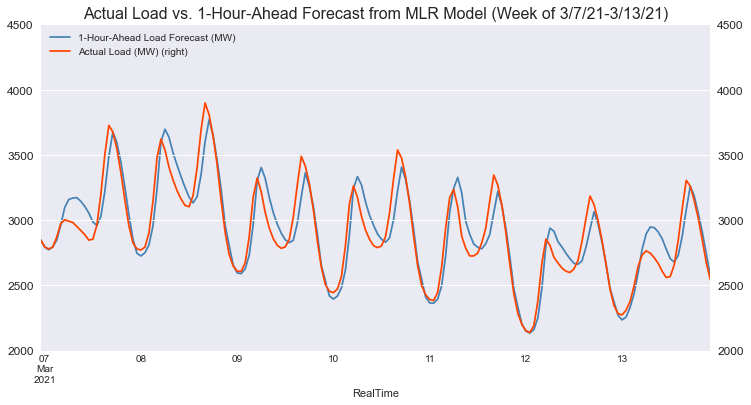

In [18]:
test_indices = list(test_df.index)

# Intialize 
pred_df = connecticut[["Date","LocalDt","LoadMW_Plus1"]].iloc[test_indices] # Get dates with same indices as in our test dataset
pred_df["y_hat"] = preds

test_dates = ['2021-03-07','2021-03-08','2021-03-09','2021-03-10','2021-03-11','2021-03-12','2021-03-13']
firstweek = pred_df[pred_df["Date"].isin(test_dates)]
firstweek

chart_data = firstweek
chart_data.dtypes

chart_data["RealTime"] = chart_data["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M") - timedelta(hours=1)
)
chart_data = chart_data.sort_values(["RealTime"], ascending=True)

chart_data = chart_data.set_index(pd.to_datetime(chart_data.RealTime), drop=True)


# Plot
#plt.style.use("default")

plt.figure(figsize=(12,6))
plt.xticks(fontsize=12)

ax1 = chart_data.y_hat.plot(color='steelblue', grid=False, label="1-Hour-Ahead Load Forecast (MW)")
ax1.set_ylim([2000, 4500])
plt.yticks(fontsize=12)
ax2 = chart_data.LoadMW_Plus1.plot(color='orangered', grid=False, secondary_y=True, label="Actual Load (MW)")
ax2.set_ylim([2000, 4500])
plt.yticks(fontsize=12)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.title('Actual Load vs. 1-Hour-Ahead Forecast from MLR Model (Week of 3/7/21-3/13/21)', fontdict = {'fontsize' : 16})

plt.legend(h1+h2, l1+l2, loc=2)

#plt.show()
plt.savefig('figures/mlr_model_results.eps', format='eps')

/var/folders/tc/ky0xv15j47z6fxhf6cykcv040000gn/T/ipykernel_16272/3097364898.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_data["RealTime"] = chart_data["LocalDt"].apply(


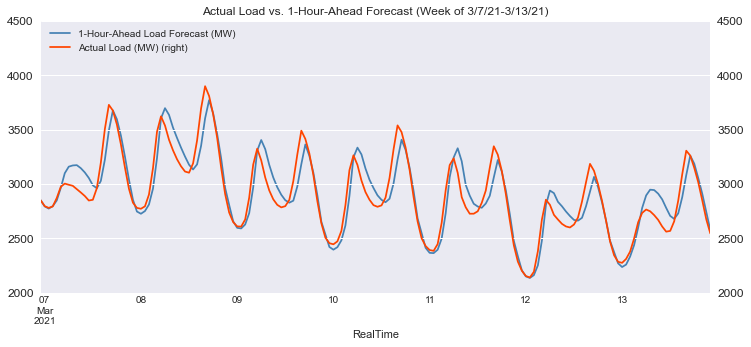

In [16]:
test_indices = list(test_df.index)

# Intialize 
pred_df = connecticut[["Date","LocalDt","LoadMW_Plus1"]].iloc[test_indices] # Get dates with same indices as in our test dataset
pred_df["y_hat"] = preds

test_dates = ['2021-03-07','2021-03-08','2021-03-09','2021-03-10','2021-03-11','2021-03-12','2021-03-13']
firstweek = pred_df[pred_df["Date"].isin(test_dates)]
firstweek

chart_data = firstweek
chart_data.dtypes

chart_data["RealTime"] = chart_data["LocalDt"].apply(
    lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M") - timedelta(hours=1)
)
chart_data = chart_data.sort_values(["RealTime"], ascending=True)

chart_data = chart_data.set_index(pd.to_datetime(chart_data.RealTime), drop=True)


# Plot
#plt.style.use("default")

plt.figure(figsize=(12,5))
plt.xticks(fontsize=24)

ax1 = chart_data.y_hat.plot(color='steelblue', grid=False, label="1-Hour-Ahead Load Forecast (MW)")
ax1.set_ylim([2000, 4500])
plt.yticks(fontsize=12)
ax2 = chart_data.LoadMW_Plus1.plot(color='orangered', grid=False, secondary_y=True, label="Actual Load (MW)")
ax2.set_ylim([2000, 4500])
plt.yticks(fontsize=12)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.title('Actual Load vs. 1-Hour-Ahead Forecast (Week of 3/7/21-3/13/21)')

plt.legend(h1+h2, l1+l2, loc=2)

plt.show()